# Load VGG

In [1]:
import os.path
import tensorflow as tf
import helper
from helper import (
    weight_variable, 
    bias_variable, 
    conv2d, 
    conv2d_transpose_strided
)

import project_tests as tests

import numpy as np
import matplotlib.pyplot as plt

### Test

In [2]:
vgg_path = 'data/vgg'
sess = tf.Session()

someinfo = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)

INFO:tensorflow:Restoring parameters from b'data/vgg/variables/variables'


In [6]:
g = tf.get_default_graph()

In [9]:
n = np.array([n for n in g.as_graph_def().node if '_out' in n.name])

In [10]:
req = ['image_input','keep_prob','layer3_out','layer4_out','layer7_out']

In [11]:
[g.get_tensor_by_name( r + ":0") for r in req]

[<tf.Tensor 'image_input:0' shape=(?, ?, ?, 3) dtype=float32>,
 <tf.Tensor 'keep_prob:0' shape=<unknown> dtype=float32>,
 <tf.Tensor 'layer3_out:0' shape=(?, ?, ?, 256) dtype=float32>,
 <tf.Tensor 'layer4_out:0' shape=(?, ?, ?, 512) dtype=float32>,
 <tf.Tensor 'layer7_out:0' shape=(?, ?, ?, 4096) dtype=float32>]

### Functions

In [2]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer3_out)
    """ 
    _ = tf.saved_model.loader.load(sess, ['vgg16'], vgg_path)
    
    return (tf.get_default_graph().get_tensor_by_name( r + ":0") for r in ['image_input','keep_prob','layer3_out','layer4_out','layer7_out'])

tests.test_load_vgg(load_vgg, tf)

Tests Passed


In [3]:
def p(x):
    print(x.shape)

In [4]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
#     p(vgg_layer3_out)
#     p(vgg_layer4_out)
#     p(vgg_layer7_out)
    
    W8 = weight_variable([1, 1, 4096, num_classes], name="W8_1")
    b8 = bias_variable([num_classes], name="b8_1")
    conv8 = conv2d(vgg_layer7_out, W8, b8)
#     p(conv8)
    
    
    deconv_shape1 = vgg_layer4_out.get_shape()
    W_t1 = weight_variable([4, 4, deconv_shape1[3].value, num_classes], name="W_t1")
    b_t1 = bias_variable([deconv_shape1[3].value], name="b_t1")
    conv_t1 = conv2d_transpose_strided(conv8, W_t1, b_t1, output_shape=tf.shape(vgg_layer4_out))
    fuse_1 = tf.add(conv_t1, vgg_layer4_out, name="fuse_1")
#     p(fuse_1)
    
    deconv_shape2 = vgg_layer3_out.get_shape()
    W_t2 = weight_variable([4, 4, deconv_shape2[3].value, deconv_shape1[3].value], name="W_t2")
    b_t2 = bias_variable([deconv_shape2[3].value], name="b_t2")
    conv_t2 = conv2d_transpose_strided(fuse_1, W_t2, b_t2, output_shape=tf.shape(vgg_layer3_out))
    fuse_2 = tf.add(conv_t2, vgg_layer3_out, name="fuse_2")
#     p(fuse_2)
    
    batch_size = tf.shape(fuse_2)[0]
    # height = tf.shape(fuse_2)[1]
    # width = tf.shape(fuse_2)[2]
    height, width = 160, 576
#     print(batch_size, height, width, num_classes)
    deconv_shape3 = tf.stack([batch_size, height, width, num_classes])
#     p(deconv_shape3)
    
    # deconv_shape3 = [None, None, None, num_classes]
    W_t3 = weight_variable([16, 16, num_classes, deconv_shape2[3].value], name="W_t3")
    b_t3 = bias_variable([num_classes], name="b_t3")
    conv_t3 = conv2d_transpose_strided(fuse_2, W_t3, b_t3, output_shape=deconv_shape3, stride=8)
#     p(conv_t3)
    
    return conv_t3

tests.test_layers(layers)

Tests Passed


In [5]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1, num_classes))
    
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label, name="entropy"))

    optimizer = tf.train.AdamOptimizer(learning_rate)
    # optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
    
    grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables())
    train_op = optimizer.apply_gradients(grads)
    
    return logits, train_op, loss

tests.test_optimize(optimize)

Tests Passed


In [6]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    
    lossess = []
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        for idx, (train_images, train_gt) in enumerate(get_batches_fn(batch_size)):
            feed_dict = {input_image: train_images, correct_label: train_gt, keep_prob: 0.85}
            sess.run(train_op, feed_dict=feed_dict)
            
            if idx%20 == 0:
                train_loss = sess.run([cross_entropy_loss], feed_dict=feed_dict)
                print("[{}/{}] Loss: {:.2f}".format(idx, epoch, train_loss[0]))
                lossess.append(train_loss[0])
    
    return lossess
                
# tests.test_train_nn(train_nn)

In [9]:
num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'
tests.test_for_kitti_dataset(data_dir)

# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

# OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
# You'll need a GPU with at least 10 teraFLOPS to train on.
# https://www.cityscapes-dataset.com/

tf.reset_default_graph()
    
vgg_path = './data/vgg'
epochs, batch_size, learning_rate = 4, 8, 1e-4
with tf.Session() as sess:
    # Create function to get batches
    get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)
    
    # OPTIONAL: Augment Images for better results
    #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network
    
    correct_label = tf.placeholder(tf.float32, [None, None, None, num_classes])
    
    # TODO: Build NN using load_vgg, layers, and optimize function
    input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
    layers_output = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)
    logits, train_op, cross_entropy_loss = optimize(layers_output, correct_label, learning_rate, num_classes)
    
    # TODO: Train NN using the train_nn function
    lossess = train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image, correct_label, keep_prob, learning_rate)
    
    # TODO: Save inference data using helper.save_inference_samples
    helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
    

Tests Passed
INFO:tensorflow:Restoring parameters from b'./data/vgg/variables/variables'
[0/0] Loss: 127.42
[20/0] Loss: 4.62
[0/1] Loss: 0.95
[20/1] Loss: 0.33
[0/2] Loss: 0.25
[20/2] Loss: 0.15
[0/3] Loss: 0.19
[20/3] Loss: 0.14
Training Finished. Saving test images to: ./runs/1499290655.9898217


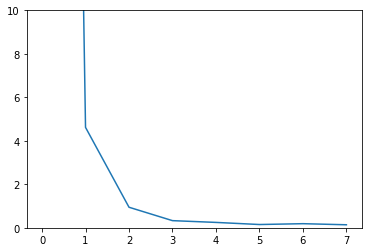

In [10]:
plt.plot(lossess)
plt.ylim([0, 10])
plt.show()

In [13]:
from IPython.display import Image
Image(filename='./runs/1499290655.9898217/um_000006
      .png')

SyntaxError: EOL while scanning string literal (<ipython-input-13-5c2824508f80>, line 2)